In [356]:
# Author: Chase J. Shyu
# Email: iamhemry@gmail.com
# Created date: June 3rd, 2021
# Updated date: June 10th, 2021
import datetime, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

In [357]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib?lq=1
def gradient_fill(x, y, fill_color=None, palpha=1, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y,color=fill_color, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, palpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = mpatches.Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    patche = mpatches.Patch(color=fill_color,alpha=palpha)

    ax.autoscale(True)
    return line, patche

In [358]:
# 2021/04台灣人口 23,514,196
# Wikipedia: https://zh.wikipedia.org/zh-tw/臺灣人口
population_202104 = 23514196
pop_cities = pd.read_csv('populations.csv')
pop202104_cities = dict(zip(pop_cities.iloc[:,0].tolist(),pop_cities.iloc[:,1].tolist()))
vaccine_prec = 0.65
vacNumber = round(population_202104*vaccine_prec*2)
first_date = datetime.datetime.fromisoformat('2021-03-01')
last_date = datetime.datetime.today() #+ datetime.timedelta(days=-1)

# for read data
# data all from CDC
csv_filename = 'VaccineCOVID19Taiwan - public.csv'
Date = '日期'
Event = '事件'
ReleasedVaccine = '累計疫苗釋出'
VaccineCheck = '疫苗檢查'
InjectedAmount = '累計施打'
InjectedAmountCorrect = '校正累計施打'
ConfirmedLocalAmount = '累計本土確診'
ConfirmedLocalDaily = '單日本土確診'
ConfirmedLocalCorrectDaily = '單日本土增補'
DeathAmount = '累計死亡'
DeathDaily = '單日死亡'
ArrivedAmount = '累計疫苗抵臺'
FinalCorrectAmount = '完成本土增補'

# read data
df = pd.read_csv(csv_filename)
df = df[~df[Date].isnull()]
df.loc[:,Date] = df[Date].astype('datetime64[ns]')
df.set_index(Date,inplace=True)
ind = (df.index >= first_date + datetime.timedelta(days=-1)) * (df.index < last_date)
df = df[ind]
df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmountCorrect] = \
    df.loc[(last_date+datetime.timedelta(days=-1)).strftime('%Y-%m-%d'),InjectedAmount]

ind = df[InjectedAmountCorrect].isnull()
df[InjectedAmountCorrect][ind] = df[InjectedAmount][ind]
df['mavg'] = df[InjectedAmountCorrect].interpolate()

#
covid_ylim_max = 800
covid_y_interval = 200
covid_y_interval_minor = 100
vac_ylim_times = 1
vacc_ylim_max = 1450
prog_ylim_max = 11
prog_y_interval = 2
vacc_y_interval = 1
vacc_y_interval_minor = 0.5
figsize = (18, 12)

# for plot
title = '臺灣COVID-19疫苗接種統計報表'
title_prog = '臺灣COVID-19疫苗取得/使用進度'
label_right = '新增本土確診/死亡(人)'
label_left = '疫苗接種(%)'
label_bottom = '事件/統計日期(西元)'
label_taiwan_vac = '臺灣疫苗接種(%)'
label_confirmed = '新增本土確診(人)'
label_correction = '累計校正回歸(人)'
label_death = '新增死亡(人)'
text_population = '臺灣人口基數(2021-04)：'+ f'{population_202104:,}' +'人'
text_last_updated = '最後更新日期：%s'%df.index[-1].strftime('%Y-%m-%d')
confirmedAmount = int(df[ConfirmedLocalAmount].max())
deathDeath = int(df[DeathAmount].max())
text_confirmed_amount = '累計本土確診/死亡：' + f'{confirmedAmount:,}/' + f'{deathDeath:,}' +'人'
text_vaccine_estimation = '假設總人口x2x%d'%(vaccine_prec*100) + '%：' + f'{vacNumber:,}' + '劑'
text_sign = '資料整理/繪圖：Chase J. Shyu'

label_sub_bottom = '事件日期(西元)'
label_dose_number = '數量(千劑)'
label_progress = '疫苗取得(%)'
label_await = '待檢驗(千劑)'
label_available = '可施打(千劑)'

label_legend_background = ['第一級','第二級','第三級','感染','疫苗']
title_legend_background ='全國疫情警戒                事件'

vaccine_color = '#6F00D2'
color_city_vaccine = '#CA8EFF'
color_city_marker = '#8080C0'
alpha_city_vaccine = 1
death_color = 'red'
confirmd_color = '#FFAD86'
correction_color = 'gold'
#progress_axis_color = 'black'
#progress_color
progress_text_color = 'black'
number_color = '#5B00AE'
availble_color = 'blue'
await_color = 'red'
title_size = 36
label_size = 20
tick_size = 16
legend_title_size = 12
subplot_label_size = 12
event_size = 10
main_alpha = 1
vaccine_lw = 2
sub_lw = 1.5

# infected dates
dates_infected = ['2021-04-22','2021-04-29','2021-05-11','2021-05-12','2021-05-23','2021-06-01']

# background zones
alpha_level1 = 0.2
color_level1 = 'lightgreen'
alpha_level2 = 0.2
color_level2 = 'gold'
alpha_level3 = 0.2
color_level3 = 'orange'
alpha_alert = 1
color_alert = '#FFD2D2'
alpha_vaccine = 1
color_vaccine = '#D2E9FF'

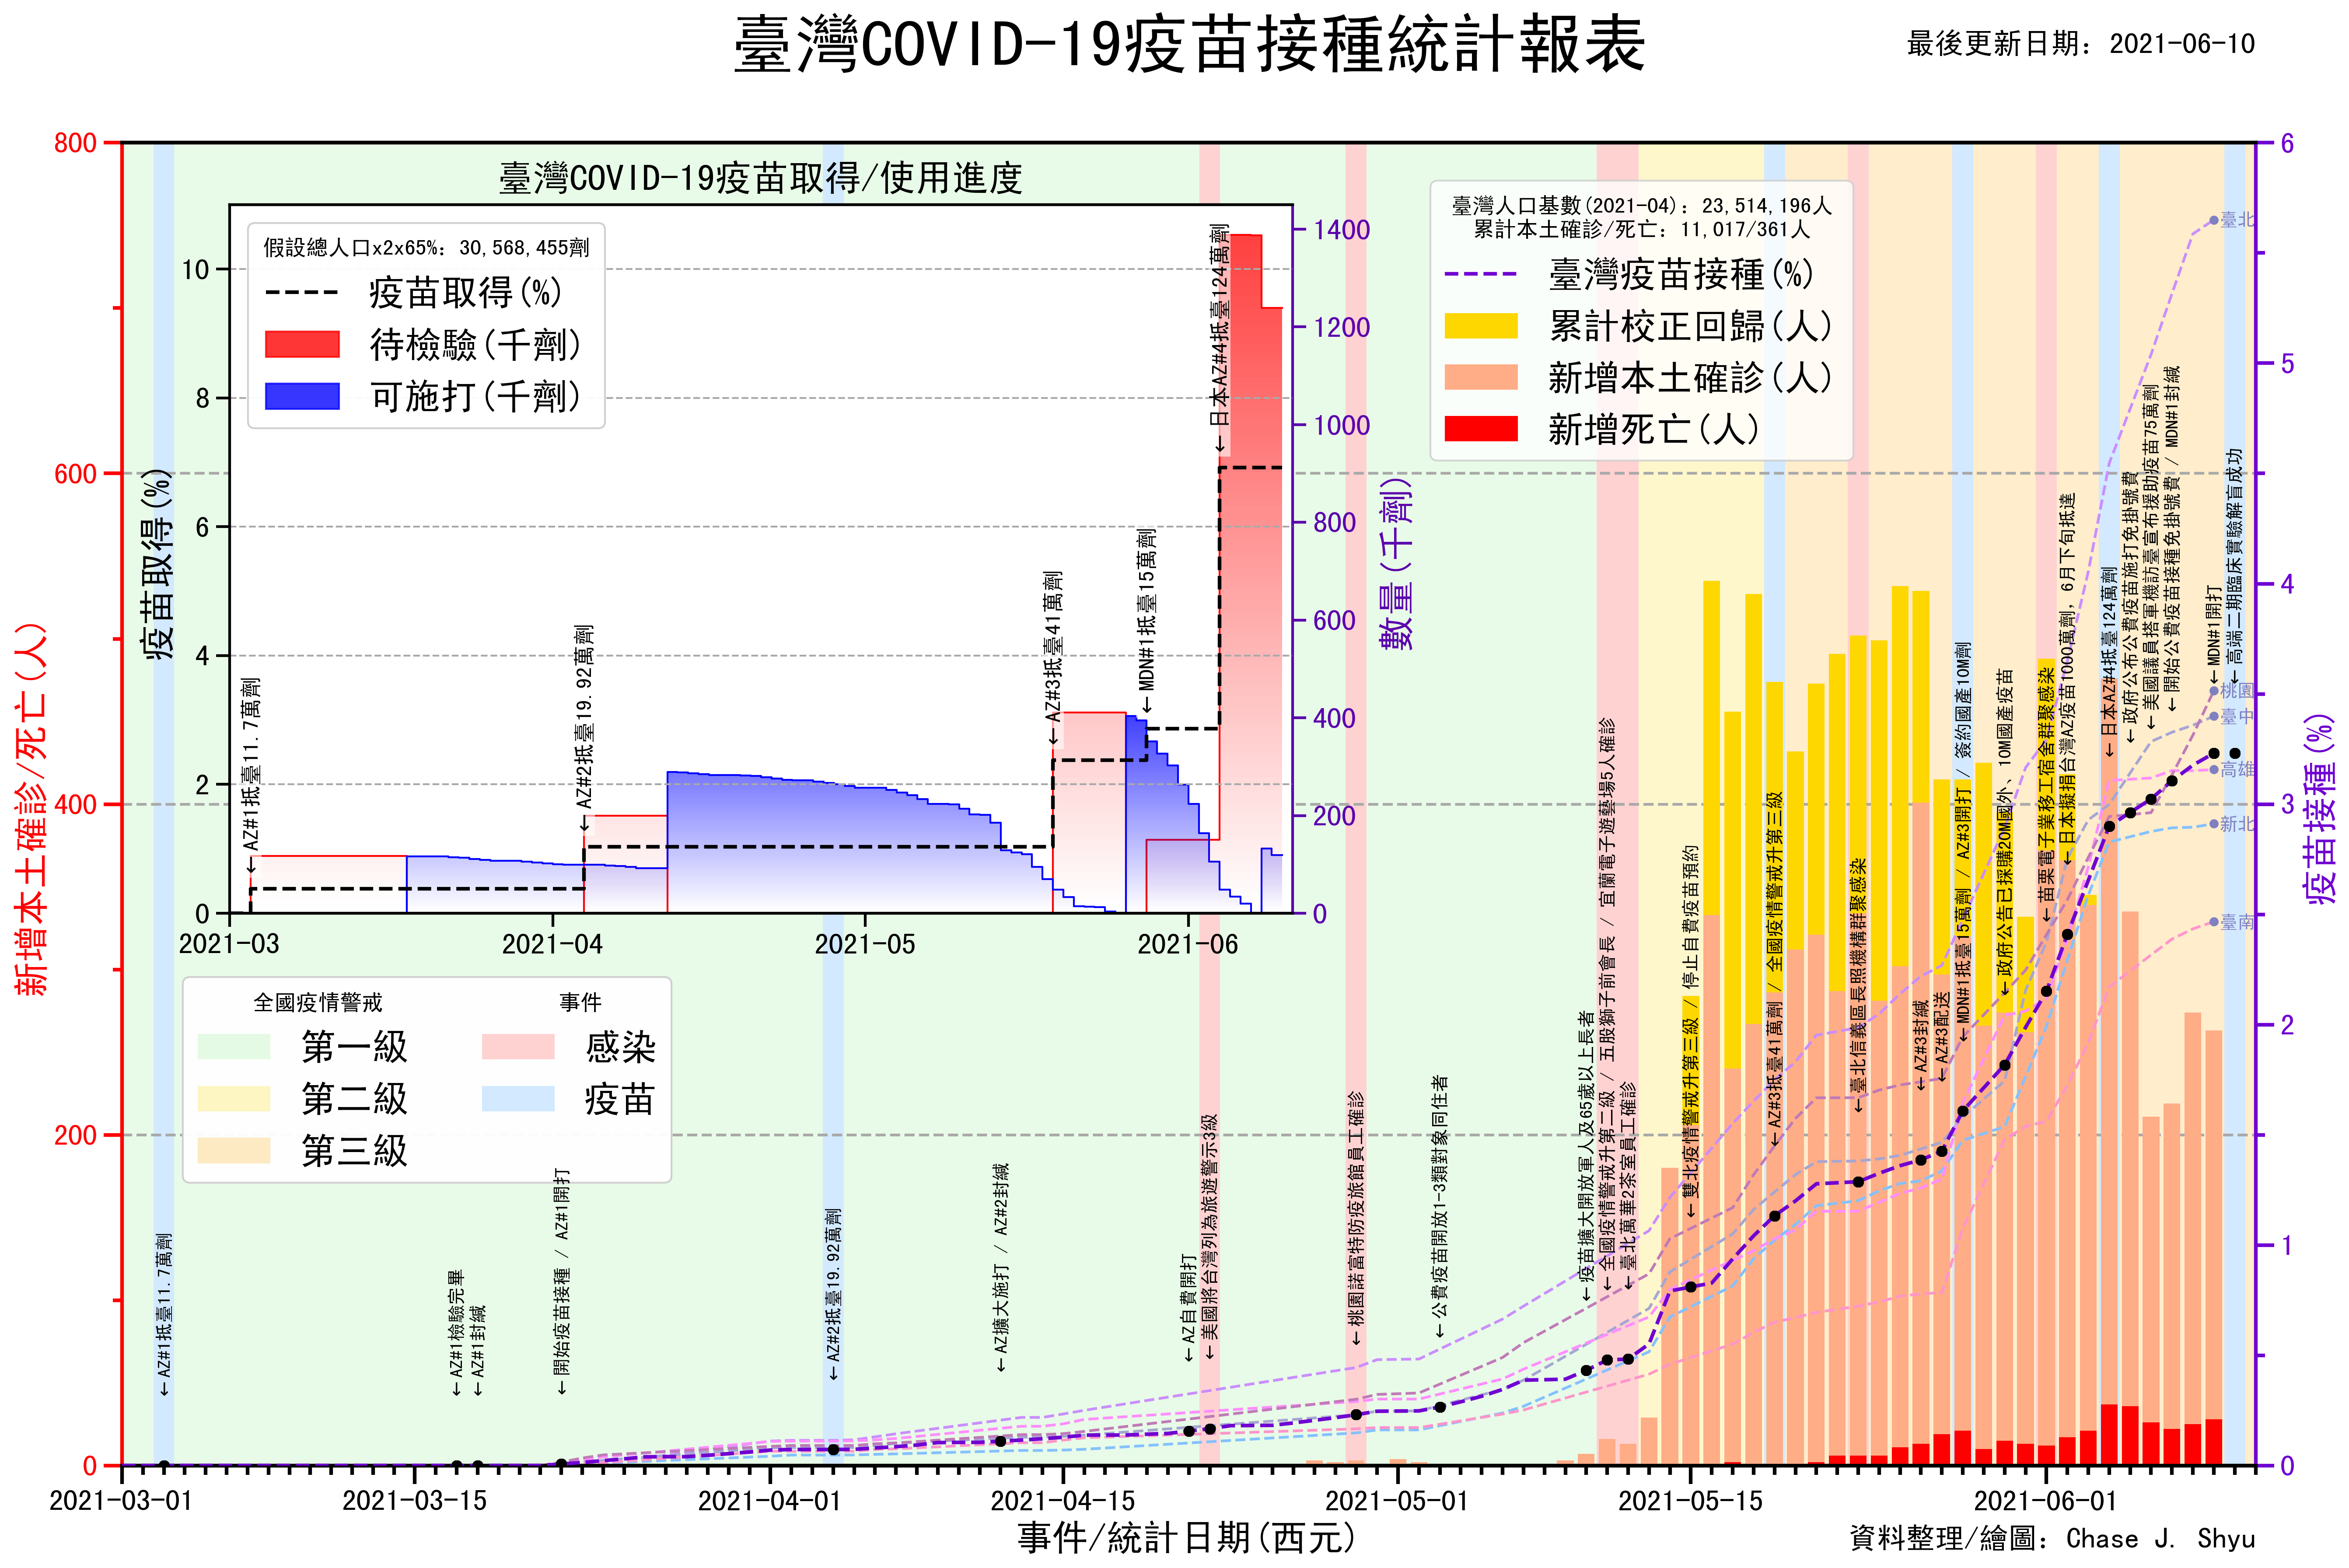

In [359]:
# plot
# https://medium.com/@jackielo_69076/mac-matplotlib-顯示中文-e10c8394300c
from matplotlib.font_manager import _rebuild
_rebuild()
font = ['SimHei','jf-jinxuan-fresh2.2']
mpl.rcParams['font.sans-serif']=[font[0]]
mpl.rcParams['axes.unicode_minus']=False

mpl.rcParams['xtick.labelsize'] = tick_size
mpl.rcParams['ytick.labelsize'] = tick_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size

fig, ax_covid = plt.subplots(1,1,figsize=figsize,dpi=300)
ax_vaccine = ax_covid.twinx()

# plot confirmed case and death
yvalue = df[ConfirmedLocalDaily] + df[FinalCorrectAmount].fillna(0)
ax_covid.bar(df.index, yvalue, color=correction_color,label=label_correction,zorder=10)
ax_covid.bar(df.index, df[ConfirmedLocalDaily], color=confirmd_color,label=label_confirmed,zorder=10)
ax_covid.bar(df.index, df[DeathDaily],color=death_color,label=label_death,zorder=10)

ax_covid.set_ylim(0,covid_ylim_max)
ax_covid.set_ylabel(label_right, fontsize=label_size)
ax_covid.set_xlabel(label_bottom, fontsize=label_size)
ax_covid.spines['left'].set_color(death_color)
ax_covid.spines['right'].set_visible(False)
ax_covid.yaxis.label.set_color(death_color)
ax_covid.tick_params(which='both',axis='y',colors=death_color)
for axis in ['top','bottom','left','right']:
    ax_covid.spines[axis].set_linewidth(2)
ax_covid.tick_params(which='major', length=10, width=2)
ax_covid.tick_params(which='minor', length=5, width=2)
#ax_covid.patch.set_alpha(main_alpha)
ax_covid.set_yticks(np.arange(0, ax_covid.get_ylim()[1]+.1, covid_y_interval))
ax_covid.set_yticks(np.arange(0, ax_covid.get_ylim()[1]+.1, covid_y_interval_minor), minor=True)
ax_covid.grid(which='major', axis='y',linestyle = '--', linewidth = 1.5,zorder=0,color='darkgray')
#ax_covid.grid(which='minor', axis='y',linestyle = '--', linewidth = 1,zorder=0,color='darkgray')

# plot vaccine injected amount
ind = (~df[InjectedAmountCorrect].isnull()) & (df.index < (last_date + datetime.timedelta(days=-1)))
ax_vaccine.plot(df.index[ind], df[InjectedAmountCorrect][ind]/population_202104*100,
                '--',color=vaccine_color, linewidth = 2,label=label_taiwan_vac,zorder=10)

# plot cities
cities = list(pop202104_cities.keys())
colors = ['#CA8EFF','#84C1FF','#A6A6D2','#FF8EFF','#C07AB8','#FF95CA']
for i in range(6):
    city = cities[i]
    col = '校正累計接種人數_' + city
    col_org = '累計接種人數_' + city
    ind = df[col].isnull()
    df[col][ind] = df[col_org][ind]
    df[col] = df[col].interpolate()
    ind = (df.index < (last_date + datetime.timedelta(days=-1)))
    yy = df[col][ind]/pop202104_cities[city]*100
    ax_vaccine.plot(df.index[ind], df[col][ind]/pop202104_cities[city]*100,'--', linewidth = 1.5,
                    alpha=alpha_city_vaccine,label='none',zorder=2,color=colors[i])#color_city_vaccine)
    xx = mdates.date2num(last_date + datetime.timedelta(hours=-16))
    ax_vaccine.text(xx,yy[-1],city[:-1],ha='center',va='center',
                    zorder=2,color=color_city_marker)
    ax_vaccine.plot(df.index[ind][-1],yy[-1],'o',mew=0,ms=5,
                    zorder=2,mfc=color_city_marker)


# text event information
y_shift = ax_vaccine.get_ylim()[1]*0.05
ind = ~df[Event].isnull() & (df.index < last_date)
#date = df.loc[ind,Date]
for i in df[ind].index:
    ycoord = df.loc[i,'mavg'] / population_202104*100
    if ycoord / ax_vaccine.get_ylim()[1] <= 0.7:
        sign = 1
        text = '$\leftarrow$'+ df.loc[i,Event]
        va = 'bottom'
    else:
        sign = -1
        text = df.loc[i,Event] + r'$\rightarrow$'
        va = 'top'
    ax_vaccine.text(i,ycoord + y_shift*sign, text, rotation=90,fontsize=event_size,
                    horizontalalignment='center',zorder=10,va=va)
    ax_vaccine.plot(df.index[ind], df.loc[ind,"mavg"]/population_202104*100 ,'o',
                    color='black',zorder=10,ms=6,mew=0)

ax_vaccine.set_yticks(np.arange(0, ax_vaccine.get_ylim()[1]+.1, vacc_y_interval))
ax_vaccine.set_yticks(np.arange(0, ax_vaccine.get_ylim()[1]+.1, vacc_y_interval_minor), minor=True)
#ax_progress.set_zorder(0)
ax_vaccine.set_ylim(0,)#math.ceil(ax_vaccine.get_ylim()[1] * vac_ylim_times))
xmax = df.index[-1]+datetime.timedelta(days=1)
ax_vaccine.set_xlim(first_date,xmax)
ax_vaccine.set_ylabel(label_left, fontsize=label_size)
ax_vaccine.set_title(title,fontsize=title_size,y=1.05)
ax_vaccine.text(xmax,ax_vaccine.get_ylim()[1]*1.065,
                text_last_updated,
               fontsize=tick_size,ha='right',va='bottom')
ax_vaccine.text(xmax,-ax_vaccine.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')
#ax_vaccine.spines['top'].set_visible(False)
ax_vaccine.spines['left'].set_visible(False)
ax_vaccine.spines['right'].set_color(vaccine_color)
for axis in ['top','bottom','left','right']:
    ax_vaccine.spines[axis].set_linewidth(2)
ax_vaccine.yaxis.label.set_color(vaccine_color)
ax_vaccine.tick_params(which='both',axis='y',colors=vaccine_color)
ax_vaccine.xaxis.set_minor_locator(mdates.DayLocator())
ax_vaccine.tick_params(which='major', length=10, width=2)
ax_vaccine.tick_params(which='minor', length=5, width=2)
#ax_vaccine.patch.set_alpha(main_alpha)

#x = (last_date+ datetime.timedelta(days=-2)).strftime('%Y-%m-%d')
#y = df.loc[last_date.strftime('%Y-%m-%d'),"mavg"]/population_202104*100
#ax_vaccine.text(x,y,'%.2f'%y + r'%$\rightarrow$',fontsize=label_size,
#                ha='right',va='center',color='blue',zorder=10,
#               bbox={'facecolor':'white', 'edgecolor':'none','alpha':0.6})

# infected events
for d in dates_infected:
    date0 = mdates.date2num(datetime.datetime.fromisoformat(d) - datetime.timedelta(hours=12))
    date1 = mdates.date2num(datetime.datetime.fromisoformat(d) + datetime.timedelta(hours=12))
    zone_alert = ax_covid.axvspan(date0, date1 , facecolor=color_alert, alpha=alpha_alert,zorder=1)

# level zones
date0 = ax_covid.get_xlim()[0]
date1 = mdates.date2num(datetime.datetime.fromisoformat('2021-05-11'))
zone_level1 = ax_covid.axvspan(date0, date1 , facecolor=color_level1, alpha=alpha_level1,zorder=0)
date2 = mdates.date2num(datetime.datetime.fromisoformat('2021-05-19'))
zone_level2 = ax_covid.axvspan(date1, date2 , facecolor=color_level2, alpha=alpha_level2,zorder=0)
date3 = ax_covid.get_xlim()[1]
zone_level3 = ax_covid.axvspan(date2, date3 , facecolor=color_level3, alpha=alpha_level3,zorder=0)

# vaccine events
ind = ~df[Event].isnull()
#date = df.loc[ind,Date]
for i in df[ind].index:
    if '抵臺' in df.loc[i,Event]:
        date0 = mdates.date2num(i - datetime.timedelta(hours=12))
        date1 = mdates.date2num(i + datetime.timedelta(hours=12))
        zone_vaccine = ax_covid.axvspan(date0, date1 , facecolor=color_vaccine, alpha=alpha_vaccine,zorder=1)
date0 = mdates.date2num(datetime.datetime.fromisoformat('2021-06-10') - datetime.timedelta(hours=12))
date1 = mdates.date2num(datetime.datetime.fromisoformat('2021-06-10') + datetime.timedelta(hours=12))
zone_vaccine = ax_covid.axvspan(date0, date1 , facecolor=color_vaccine, alpha=alpha_vaccine,zorder=1)



# plot vaccine progress
ax_vac_num = fig.add_axes([0.1, 0.42, .45, 0.45])
ax_progress = ax_vac_num.twinx()

#await vaccion
dd = np.vstack((df.index[:-1],df.index[1:])).T.reshape((1,-1),)[0]
yvalue = (df[ArrivedAmount]-df[VaccineCheck].fillna(0).cumsum()-df[ReleasedVaccine])*1e-3
aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
#ax_vac_num.plot(dd,aa,'-',color=await_color,label=label_await,lw=1,zorder=5)
lim_y_max = ax_vac_num.get_ylim()[1]
_, im_await = gradient_fill(mdates.date2num(dd),aa,await_color,ax=ax_vac_num,palpha=0.75,lw=1)

# available vaccine
dd = np.vstack((df.index[:-1],df.index[1:])).T.reshape((1,-1),)[0]

delta_vaccine = (df[ReleasedVaccine]-df['mavg'].fillna(0)) *1e-3
delta_vaccine[delta_vaccine >= 0] = pd.np.nan
ind0 = delta_vaccine.index[~delta_vaccine.isnull()][0]
delta = delta_vaccine[ind0:].interpolate()
yvalue = (df[ReleasedVaccine]-df['mavg'].fillna(0))*1e-3
yvalue[delta.index] = yvalue[delta.index] - delta
aa = np.vstack((yvalue[:-1],yvalue[:-1])).T.reshape((1,-1),)[0]
#ax_vac_num.plot(dd,aa,'-',color=availble_color,label=label_available,lw=1,zorder=5)
_, im_available = gradient_fill(mdates.date2num(dd),aa,availble_color,ax=ax_vac_num,palpha=0.75,lw=1)

ax_vac_num.set_ylabel(label_dose_number,fontsize=label_size)
ax_vac_num.set_ylim(0,vacc_ylim_max)
ax_vac_num.tick_params(which='major', length=7.5, width=1.5)

for axis in ['top','bottom','right']:
    ax_vac_num.spines[axis].set_linewidth(1.5)
ax_vac_num.spines['right'].set_color(number_color)
ax_vac_num.yaxis.label.set_color(number_color)
ax_vac_num.tick_params(axis='y',colors=number_color)
ax_vac_num.spines['left'].set_visible(False)
ax_vac_num.yaxis.tick_right()
ax_vac_num.yaxis.set_label_position("right")

ax_progress.set_xlim(first_date,df.index[-1]+datetime.timedelta(days=1))
ax_progress.set_ylim(0,prog_ylim_max)

# obtainment
dd = np.vstack((df.index[:-1],df.index[1:])).T.reshape((1,-1),)[0]
aa = np.vstack((df[ArrivedAmount][:-1],df[ArrivedAmount][:-1])).T.reshape((1,-1),)[0]
ax_progress.plot(dd,aa / (population_202104*vaccine_prec*2) * 100,'--',
                 color=progress_text_color,label=label_progress,lw=2,zorder=5)

y_shift = ax_progress.get_ylim()[1]*0.02
ind = ~df[Event].isnull()
for i in df[ind].index:
    if '抵臺' in df.loc[i,Event]:
        ycoord = df.loc[i,ArrivedAmount] / (population_202104*vaccine_prec*2) * 100 + y_shift
        ax_progress.text(i,ycoord,'$\leftarrow$'+ df.loc[i,Event].split('/')[0],
                         zorder=6,rotation=90,fontsize=event_size+2,
                         horizontalalignment='center',color=progress_text_color,
                         bbox={'facecolor':'white', 'edgecolor':'none', 'pad':0,'alpha':0.6})

ax_progress.set_title(title_prog,fontsize=label_size,y=1.005)
ax_progress.yaxis.tick_left()
ax_progress.yaxis.set_label_position("left")
ax_progress.set_xlabel(label_sub_bottom,fontsize=label_size)
ax_progress.set_ylabel(label_progress,fontsize=label_size)
ax_progress.set_yticks(np.arange(0, prog_ylim_max+.1, prog_y_interval))
ax_progress.tick_params(axis='y',labelsize=tick_size)
ax_progress.spines['right'].set_visible(False)
for axis in ['top','bottom','left']:
    ax_progress.spines[axis].set_linewidth(1.5)
ax_progress.spines['left'].set_color(progress_text_color)
ax_progress.tick_params(which='major', length=7.5, width=1.5)
ax_progress.xaxis.set_major_locator(mdates.MonthLocator())
ax_progress.yaxis.label.set_color(progress_text_color)
ax_progress.tick_params(axis='y',colors=progress_text_color)
ax_progress.grid(axis='y',linestyle = '--', linewidth = 1,color='darkgray')

# plot legend
hs0, ls0 = ax_vaccine.get_legend_handles_labels()
hs1, ls1 = ax_covid.get_legend_handles_labels()
legend1 = ax_vaccine.legend(hs0[0:1]+hs1,ls0[0:1]+ls1,loc=1,bbox_to_anchor=(0.82, 0.985),fontsize=label_size,
                            title=text_population +'\n  '+text_confirmed_amount)
ax_vaccine.add_artist(legend1)
#ax_covid.legend(loc=1,bbox_to_anchor=(0.8, 1),fontsize=label_size,title=text_confirmed_amount)
#ax_vaccine.legend(loc=1,bbox_to_anchor=(1, 1),fontsize=label_size,title=text_population +'\n  '+text_confirmed_amount)

legend_background = ax_vaccine.legend([zone_level1,zone_level2,zone_level3,zone_alert,zone_vaccine],
                                      label_legend_background,fontsize=label_size,
                                      loc=3,bbox_to_anchor=(0.02, 0.2), ncol=2,
                                      title=title_legend_background)
ax_vaccine.add_artist(legend_background)

hs0, ls0 = ax_progress.get_legend_handles_labels()
hs1, ls1 = ax_vac_num.get_legend_handles_labels()
legend1 = ax_progress.legend(hs0+[im_await,im_available],ls0+[label_await,label_available],loc=2,title=text_vaccine_estimation,fontsize=label_size)
ax_progress.add_artist(legend1)
#ax_progress.legend(loc=2,bbox_to_anchor=(0.345, 1),fontsize=label_size,title=text_vaccine_estimation)
#ax_vac_num.legend(loc=2,bbox_to_anchor=(0, 1),fontsize=label_size)

# save figure
plt.tight_layout()
plt.savefig('VaccineCOVID19Taiwan-%s.jpg'%df.index[-1].strftime('%Y-%m-%d'),dpi=300)
plt.show()
plt.close()